# EE 467 Lab 2: Breaking CAPTCHAs with PyTorch

This notebook is a PyTorch implementation of the CAPTCHA-breaking CNN, converted from the TensorFlow/Keras version. We will use the same preprocessing steps and model architecture, but implement the training and evaluation using PyTorch.

## Install Required Libraries

In [1]:
%pip install torch torchvision matplotlib scikit-learn "opencv-python>4" imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 MB 66.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 2.9.0
    Uninstalling torch-2.9.0:━━━━━━━━━━━━━━━━━━━ 0/2 [torch]
      Successfully uninstalled torch-2.9.0━━━━━━ 0/2 [torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] [torchvision]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

In [2]:
import os
import pickle
from pprint import pprint

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from imutils import paths
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

from lab_2_helpers import *

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Preprocessing
## Load and Preprocess CAPTCHA Images
Load CAPTCHA images, convert to grayscale, add padding, and split into train/validation/test sets.

In [3]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
pprint(captcha_image_paths[:10])

['./captcha-images/G5P5.png',
 './captcha-images/5VXL.png',
 './captcha-images/4NL5.png',
 './captcha-images/4GGZ.png',
 './captcha-images/G7J9.png',
 './captcha-images/E6M8.png',
 './captcha-images/7WPB.png',
 './captcha-images/5TN5.png',
 './captcha-images/L6US.png',
 './captcha-images/2A5R.png']


In [4]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
pprint(captcha_texts[:10])

['G5P5', '5VXL', '4NL5', '4GGZ', 'G7J9', 'E6M8', '7WPB', '5TN5', 'L6US', '2A5R']


Figure(2000x500)


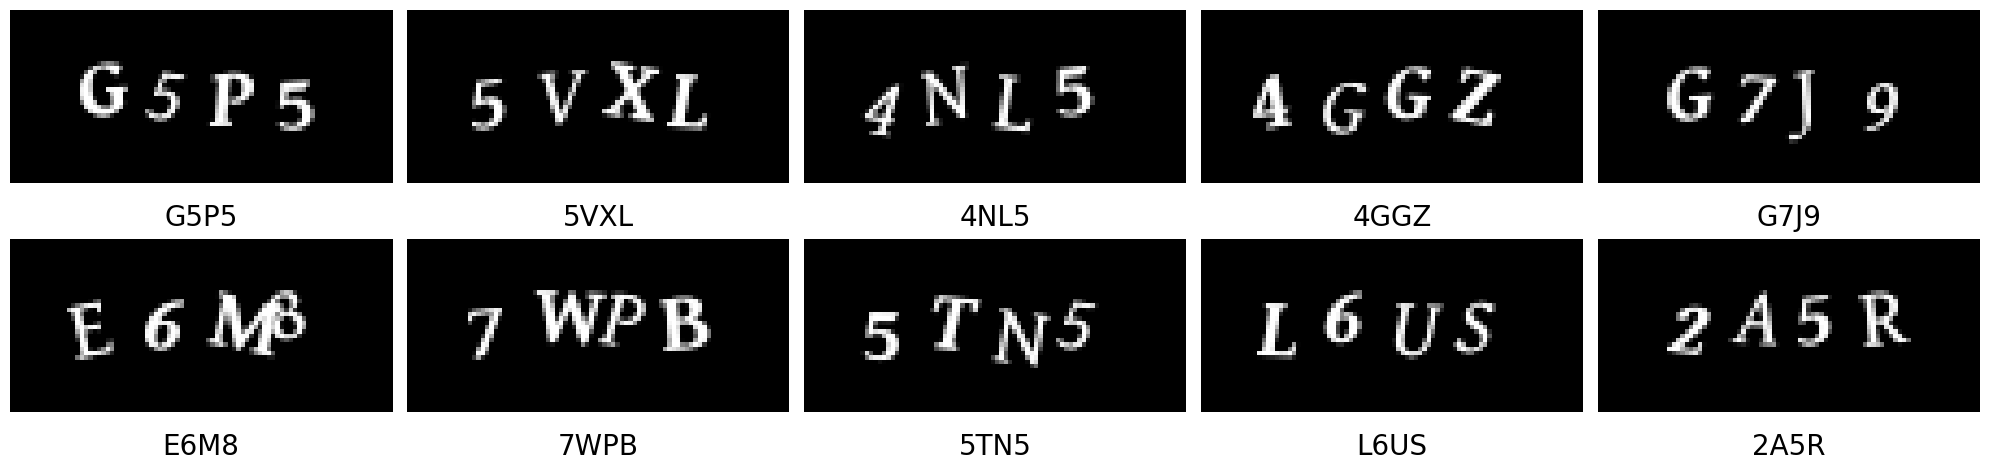

In [5]:
def load_transform_image(image_path):
    """ Load and transform image into grayscale. """
    # Load image with OpenCV
    image = cv2.imread(image_path)
    # Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Add extra padding (8px) around the image
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
# Review loaded CAPTCHAs
print_images(captcha_images[:10], n_rows=2, texts=captcha_texts[:10])

In [6]:
# Train-validation-test split seed (same as TensorFlow version for reproducibility)
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Extract Characters from CAPTCHAs
Use contour detection to find bounding boxes around characters and extract individual character images.

In [7]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """
    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w / h > 1.25:
            # Split wide bounding boxes (likely two characters)
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            char_regions.append((x, y, w, h))

    if len(char_regions) != 4:
        return None
    char_regions.sort(key=lambda x: x[0])

    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)
        char_counts[char] = char_count + 1

# Force character extraction even if results are already available
FORCE_EXTRACT_CHAR = False

char_counts = {}
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        char_images = extract_chars(captcha_image)
        if char_images is None:
            continue
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)
    print("Character extraction complete!")
else:
    print("Using existing character images.")

Using existing character images.


## Create PyTorch Dataset and DataLoader
Create a custom Dataset class for loading character images and create DataLoaders for training and validation.

In [8]:
def make_feature(image):
    """ Process character image and turn it into feature. """
    image_resized = resize_to_fit(image, 20, 20)
    return image_resized

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    label = image_path.split(os.path.sep)[-2]
    return feature, label

# Make features and labels from character image paths
features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Convert to numpy arrays
features_tv = np.array(features_tv, dtype="float32") / 255.0

# Create label encoder (converts labels to integers for PyTorch)
le = LabelEncoder()
labels_tv = le.fit_transform(labels_tv)
n_classes = len(le.classes_)

print(f"Number of classes: {n_classes}")
print(f"Classes: {le.classes_}")

Number of classes: 32
Classes: ['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [9]:
# Split into training and validation sets
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_tv, test_size=0.25, random_state=955996
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_vali)}")

Training samples: 2676
Validation samples: 892


In [10]:
class CharacterDataset(Dataset):
    """ Custom PyTorch Dataset for character images. """
    def __init__(self, features, labels):
        # Add channel dimension: (N, H, W) -> (N, 1, H, W)
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = CharacterDataset(X_train, y_train)
vali_dataset = CharacterDataset(X_vali, y_vali)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(vali_loader)}")

Training batches: 84
Validation batches: 28


# Training
## Define CNN Model Architecture
Implement the CNN using PyTorch with the same architecture as the TensorFlow version:
- Conv2D (20 filters, 5x5) + ReLU + MaxPool (2x2)
- Conv2D (50 filters, 5x5) + ReLU + MaxPool (2x2)
- Flatten
- Dense (500) + ReLU
- Dense (n_classes) + Softmax

In [11]:
class CaptchaCNN(nn.Module):
    """ CNN model for character classification (PyTorch version). """
    def __init__(self, n_classes):
        super(CaptchaCNN, self).__init__()
        
        # First convolution block: (*, 1, 20, 20) -> (*, 20, 10, 10)
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, padding=2)  # same padding
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolution block: (*, 20, 10, 10) -> (*, 50, 5, 5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, padding=2)  # same padding
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten: (*, 50, 5, 5) -> (*, 1250)
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(50 * 5 * 5, 500)  # 1250 -> 500
        self.fc2 = nn.Linear(500, n_classes)   # 500 -> n_classes
        
    def forward(self, x):
        # First conv block
        x = self.pool1(torch.relu(self.conv1(x)))
        # Second conv block
        x = self.pool2(torch.relu(self.conv2(x)))
        # Flatten
        x = self.flatten(x)
        # FC layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax here, CrossEntropyLoss handles it
        return x

# Create model
model = CaptchaCNN(n_classes).to(device)
print(model)

CaptchaCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=32, bias=True)
)


## Training Loop Implementation
Train the model using Adam optimizer and CrossEntropyLoss.

In [12]:
# Training parameters
N_EPOCHS = 10
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pth"
FORCE_TRAINING = True

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train_epoch(model, loader, criterion, optimizer, device):
    """ Train for one epoch. """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    """ Validate the model. """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(loader), correct / total

In [13]:
# Training loop
if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    print("Training the model...")
    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, vali_loader, criterion, device)
        
        print(f"Epoch {epoch+1}/{N_EPOCHS} - "
              f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")
    
    # Save model weights
    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    print(f"\nModel saved to {MODEL_WEIGHTS_PATH}")
else:
    # Load existing weights
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))
    print(f"Model loaded from {MODEL_WEIGHTS_PATH}")

Training the model...
Epoch 1/10 - loss: 2.1295 - accuracy: 0.4447 - val_loss: 0.3631 - val_accuracy: 0.9193
Epoch 2/10 - loss: 0.1933 - accuracy: 0.9567 - val_loss: 0.1177 - val_accuracy: 0.9832
Epoch 3/10 - loss: 0.0722 - accuracy: 0.9851 - val_loss: 0.0978 - val_accuracy: 0.9832
Epoch 4/10 - loss: 0.0362 - accuracy: 0.9918 - val_loss: 0.0803 - val_accuracy: 0.9843
Epoch 5/10 - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.0730 - val_accuracy: 0.9865
Epoch 6/10 - loss: 0.0126 - accuracy: 0.9978 - val_loss: 0.0810 - val_accuracy: 0.9843
Epoch 7/10 - loss: 0.0089 - accuracy: 0.9981 - val_loss: 0.0722 - val_accuracy: 0.9877
Epoch 8/10 - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0752 - val_accuracy: 0.9877
Epoch 9/10 - loss: 0.0007 - accuracy: 1.0000 - val_loss: 0.0787 - val_accuracy: 0.9877
Epoch 10/10 - loss: 0.0005 - accuracy: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.9877

Model saved to ./captcha-model-pytorch.pth


# Evaluation
## CAPTCHA Prediction Pipeline
Build the end-to-end pipeline to predict full CAPTCHAs and compute accuracy.

In [14]:
# Dummy character images for failed extractions
DUMMY_CHAR_IMAGES = [np.zeros((20, 20), dtype=np.float32) for _ in range(4)]

# Indices of CAPTCHAs on which extractions failed
extract_failed_indices = []
# Extracted character images
char_images_test = []

# Extract character images from test CAPTCHAs
for i, captcha_image in enumerate(captcha_images_test):
    char_images = extract_chars(captcha_image)
    
    if char_images:
        char_images_test.extend(char_images)
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

# Make features for character images
features_test = np.array([make_feature(img) for img in char_images_test], dtype="float32") / 255.0

# Convert to PyTorch tensor and add channel dimension
features_test_tensor = torch.tensor(features_test).unsqueeze(1).to(device)

print(f"Test features shape: {features_test_tensor.shape}")

Test features shape: torch.Size([912, 1, 20, 20])


In [15]:
# Predict labels with the trained model
model.eval()
with torch.no_grad():
    outputs = model(features_test_tensor)
    _, predicted = torch.max(outputs, 1)
    preds_test = predicted.cpu().numpy()

# Convert predicted indices back to character labels
preds_test = le.inverse_transform(preds_test)

# Group all 4 characters for the same CAPTCHA
preds_test = ["".join(chars) for chars in group_every(preds_test, 4)]

# Update result for CAPTCHAs on which extractions failed
for i in extract_failed_indices:
    preds_test[i] = "-"

print(f"Sample predictions: {preds_test[:5]}")

Sample predictions: ['4JS9', '4GW2', '2DTC', '4L33', '3EM4']


## Compute Accuracy and Display Results

In [16]:
# Number of CAPTCHAs to display
N_DISPLAY_SAMPLES = 10

# Number of test CAPTCHAs
n_test = len(captcha_texts_test)
# Number of correct predictions
n_correct = 0

# Indices of correct predictions
correct_indices = []
# Indices of incorrect predictions
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text == actual_text:
        n_correct += 1
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

# Show number of total / correct predictions and accuracy
print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct / n_test, "\n")

# of test CAPTCHAs: 228
# correctly recognized: 216
Accuracy: 0.9473684210526315 



Correct Predictions:
Figure(2000x500)


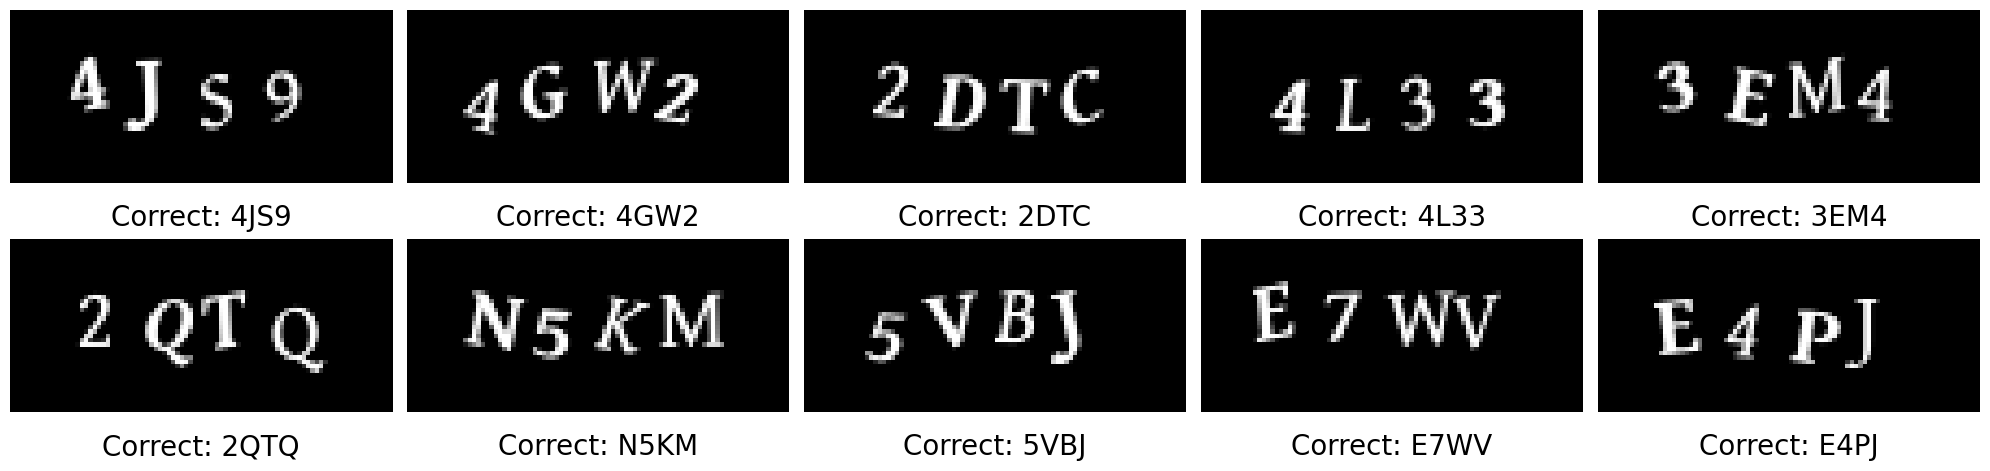

In [18]:
# Show all correct predictions
print("Correct Predictions:")
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

Incorrect Predictions:
Figure(2000x600)


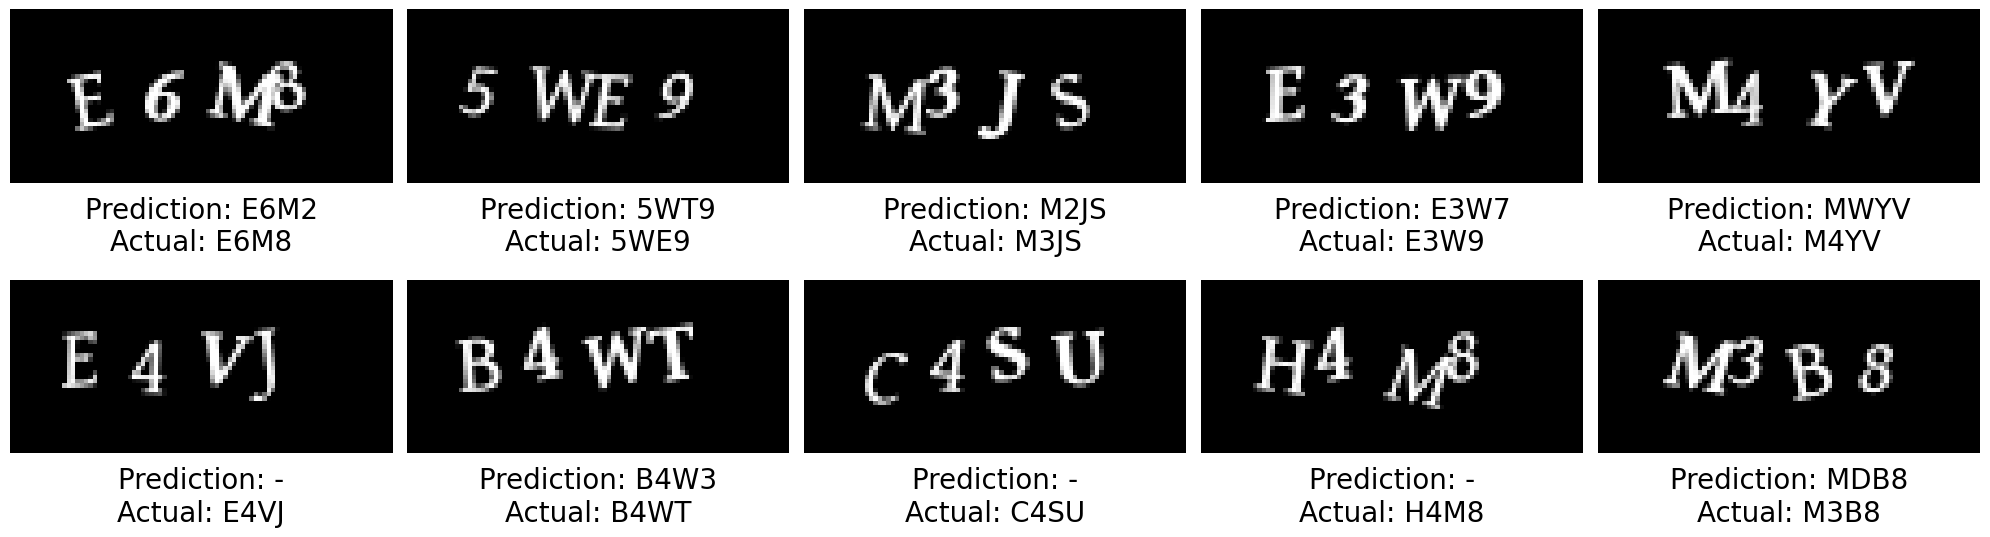

In [19]:
# Show all incorrect predictions
print("Incorrect Predictions:")
print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[
        f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}"
        for i in incorrect_indices
    ],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)

## Summary

This PyTorch implementation follows the same architecture and preprocessing as the TensorFlow/Keras version:

| Component | TensorFlow/Keras | PyTorch |
|-----------|------------------|---------|
| Conv Layer 1 | `Conv2D(20, (5,5), 'relu', 'same')` | `nn.Conv2d(1, 20, 5, padding=2)` + `ReLU` |
| Pool Layer 1 | `MaxPooling2D((2,2))` | `nn.MaxPool2d(2)` |
| Conv Layer 2 | `Conv2D(50, (5,5), 'relu', 'same')` | `nn.Conv2d(20, 50, 5, padding=2)` + `ReLU` |
| Pool Layer 2 | `MaxPooling2D((2,2))` | `nn.MaxPool2d(2)` |
| Flatten | `Flatten()` | `nn.Flatten()` |
| Dense 1 | `Dense(500, 'relu')` | `nn.Linear(1250, 500)` + `ReLU` |
| Dense 2 | `Dense(n_classes, 'softmax')` | `nn.Linear(500, n_classes)` |
| Loss | `categorical_crossentropy` | `nn.CrossEntropyLoss()` |
| Optimizer | `Adam` | `optim.Adam()` |

The results should be similar to the TensorFlow version (minor differences are expected due to random initialization and implementation details).